# Estudo de caso: problema de 2 e 3 corpos

- [x] Copiar solução dois corpos
- [x] Análise da energia
- [x] Referencial do CM
- [ ] Alterar dimensões
  - 1 kg colisão
  - 1 kg orbita
- [ ] 3 corpos


## Solução numérica utilizando a biblioteca SciPy

In [1]:
# Importando as Bibliotecas necessárias

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

G = 6.67430e-20  # Constante Gravitacional, km**3/(kg * s**2)

# Condições Iniciais

m_1 = 1.0e26  # kg
m_2 = 1.0e26  # kg

R_1_0 = np.array((0, 0, 0))  # km
R_2_0 = np.array((3000, 0, 0))  # km
dotR_1_0 = np.array((10, 20, 40))  # km/s
dotR_2_0 = np.array((0, 40, 0))  # km/s

s_0 = np.hstack((R_1_0, R_2_0, dotR_1_0, dotR_2_0)) # vetor de estado inicial


In [2]:
def two_body_motion(_s, _t, _G, _m_1, _m_2):
  """
  differential equations of motion describing the two-body-problem
  _t: discrete time step value
  _y: state vector
  """

  R_1 = _s[:3]
  R_2 = _s[3:6]

  dotR_1 = _s[6:9]
  dotR_2 = _s[9:]

  r = np.sqrt(np.sum(np.square(R_2 - R_1)))

  ddot = _G * (R_2 - R_1) / r**3
  ddotR_1 = _m_2 * ddot
  ddotR_2 = -_m_1 * ddot

  return np.concatenate((dotR_1, dotR_2, ddotR_1, ddotR_2))


t = np.linspace(0, 480, 1000)

# Solução da EDO

tb_solution = odeint(two_body_motion, s_0, t, args=(G, m_1, m_2))

print("Dimensões da matriz:", tb_solution.shape)

# Vetor auxiliar para a plotagem dos gráficos
plot_m1 = tb_solution[:,:3]
plot_m2 = tb_solution[:,3:6]

Dimensões da matriz: (1000, 12)


<ipython-input-3-ddb85dfd0f8f>:16: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


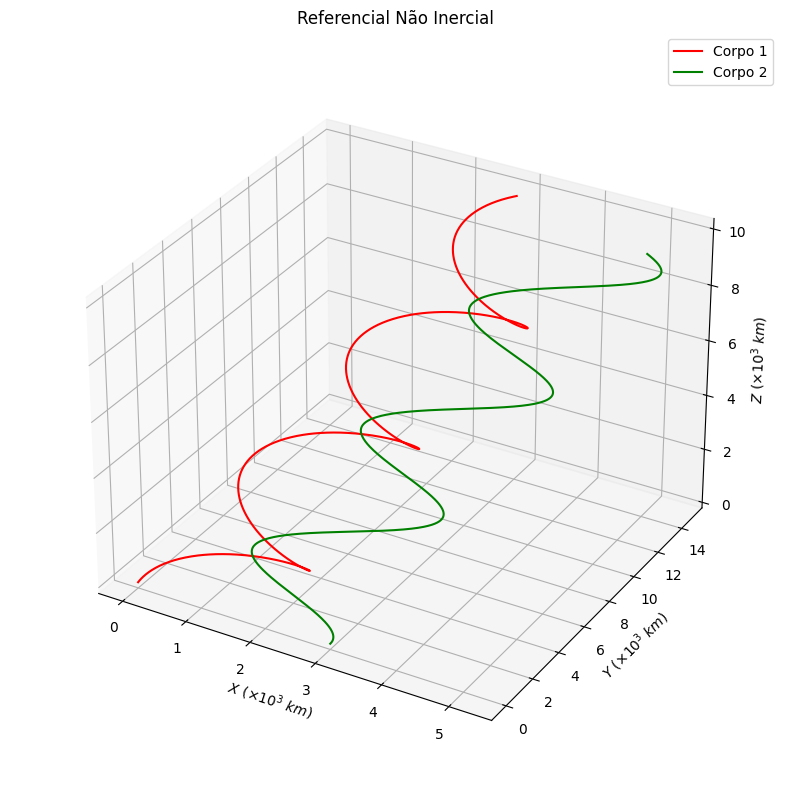

In [3]:
# Plotagem do gráfico:

fig = plt.figure(figsize =(10, 10))
ax = plt.axes(projection="3d")

ax.plot3D(plot_m1[:,0]/1000, plot_m1[:,1]/1000, plot_m1[:,2]/1000, 'red', label='Corpo 1')
ax.plot3D(plot_m2[:,0]/1000, plot_m2[:,1]/1000, plot_m2[:,2]/1000, 'green', label='Corpo 2')

ax.legend()

plt.title("Referencial Não Inercial")
ax.set_xlabel('$X \ (× 10^3 \ km)$')
ax.set_ylabel('$Y \ (× 10^3 \ km)$')
ax.set_zlabel('$Z \ (× 10^3 \ km)$')

ax.dist = 11
plt.show()

## Análise da Energia

In [4]:
def getEnergy( pos, vel, mass, G ):
	"""
	Get kinetic energy (KE) and potential energy (PE) of simulation
	pos is N x 3 matrix of positions
	vel is N x 3 matrix of velocities
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	KE is the kinetic energy of the system
	PE is the potential energy of the system
	"""
	# Energia Cinética:

	KE = 0.5 * np.sum(np.sum( mass * vel**2 ))


	# Energia Potencial:

	# positions r = [x,y,z] for all particles
	x = pos[:,0:1]
	y = pos[:,1:2]
	z = pos[:,2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z

	# matrix that stores 1/r for all particle pairwise particle separations
	inv_r = np.sqrt(dx**2 + dy**2 + dz**2)
	inv_r[inv_r>0] = 1.0/inv_r[inv_r>0]

	# sum over upper triangle, to count each interaction only once
	PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))

	return KE, PE;

In [5]:
K = []
U = []
Em = []

for i in range(len(tb_solution)):
  pos = np.array([tb_solution[i, 0:3], tb_solution[i, 3:6]])

  vel = np.array([tb_solution[i, 6:9], tb_solution[i, 9:12]])

  mass = np.array([[m_1], [m_2]])

  EK, EU = getEnergy(pos, vel, mass, G)

  K.append(EK)
  U.append(EU)

  Em.append(EK + EU)


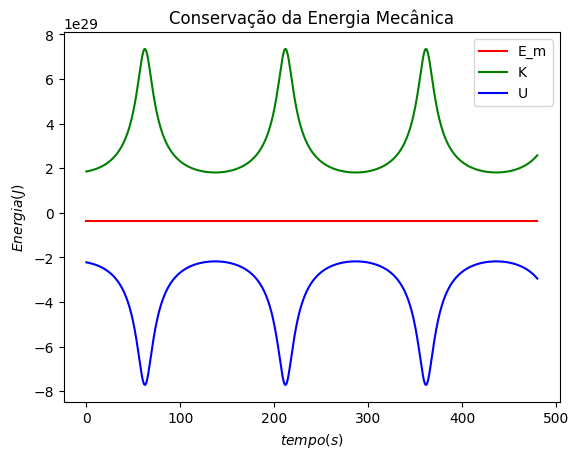

In [6]:
fig = plt.figure()

plt.plot(t, Em, 'red', label='E_m')
plt.plot(t, K, 'green', label='K')
plt.plot(t, U, 'blue', label='U')
plt.legend()

plt.title("Conservação da Energia Mecânica")
plt.xlabel('$tempo (s)$')
plt.ylabel('$Energia (J)$')

plt.show()

## Movimento do Sistema no referencial do Centro de Massa

In [7]:
# Resultados da simulação:
state_history = []

tb_solution = odeint(two_body_motion, s_0, t, args=(G, m_1, m_2))

for yk in tb_solution:
    # extract inertial positions of body 1 and body 2
    r1 = yk[:3]
    r2 = yk[3:6]

    # determine position of centre of mass
    rg = ((m_1 * r1) + (m_2 * r2)) / (m_1 + m_2)

    # position vector from m1 to m2
    r12 = r2 - r1

    # position vector from m1 to g
    r1g = rg - r1

    # position vector from g to m1
    rg1 = r1 - rg

    # position vector from g to m2
    rg2 = r2 - rg

    # save state history (yk = 0-11, rg = 12-14, r12=15-17, ...)
    #state_history.append(np.concatenate((yk, rg, r12, r1g, rg1, rg2), axis=None))

    state_history.append(np.concatenate((rg1, rg2), axis=None))


# convert list to numpy array
state_history = np.array(state_history)


# Vetor auxiliar para a plotagem dos gráficos
plot_m1 = state_history[:,:3]
plot_m2 = state_history[:,3:6]


<ipython-input-8-be629c41963c>:17: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


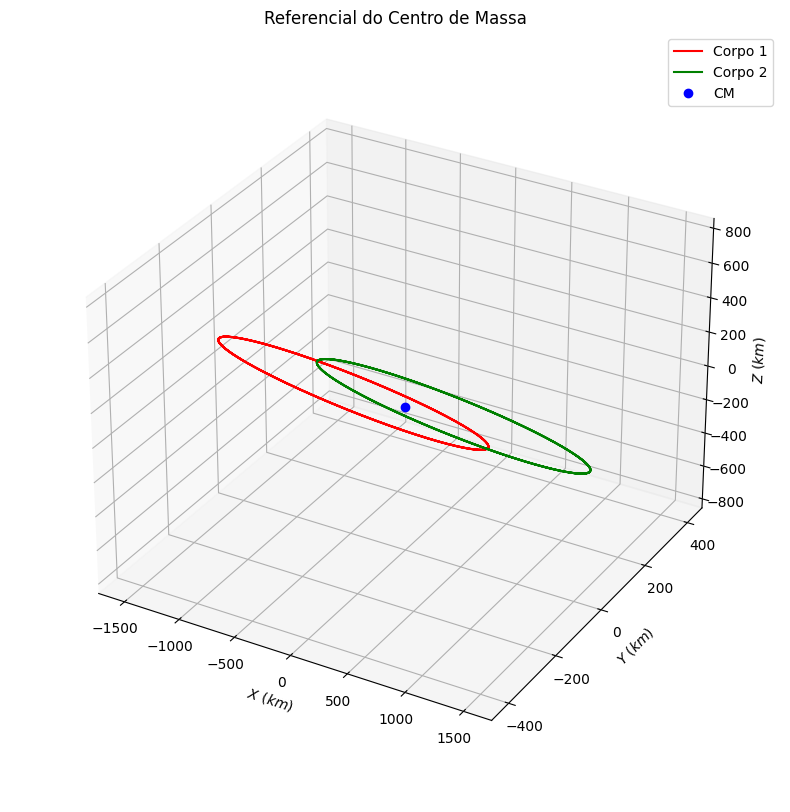

In [8]:
# Plotagem do gráfico:

fig = plt.figure(figsize =(10,10))
ax = plt.axes(projection="3d")

ax.plot3D(plot_m1[:,0], plot_m1[:,1], plot_m1[:,2], 'red', label='Corpo 1')
ax.plot3D(plot_m2[:,0], plot_m2[:,1], plot_m2[:,2], 'green', label='Corpo 2')
ax.plot3D([0], [0], [0], 'o', label = 'CM', linewidth = 15, color = 'blue')

ax.legend()

plt.title("Referencial do Centro de Massa")
ax.set_xlabel('$X \ (km)$')
ax.set_ylabel('$Y \ (km)$')
ax.set_zlabel('$Z \ (km)$')

ax.dist = 11
plt.show()

## Variação das Dimensões

In [9]:
# Importando as Bibliotecas necessárias

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

#G = 6.67430e-20  # Constante Gravitacional, km**3/(kg * s**2)
G = 0.498 #  Constante Gravitacional, m**3/(kg * dia**2)

# Condições Iniciais 1
'''
m_1 = 1.0e26  # kg
m_2 = 1.0e26  # kg

R_1_0 = np.array((0, 0, 0))  # km
R_2_0 = np.array((3000, 0, 0))  # km
dotR_1_0 = np.array((10, 20, 30))  # km/s
dotR_2_0 = np.array((0, 40, 0))  # km/s
'''

# Condições Iniciais 2

m_1 = 1.0  # kg
m_2 = 1.0  # kg

R_1_0 = np.array((0, 0, 0))  # m
R_2_0 = np.array((20, 0, 0))  # m
dotR_1_0 = np.array((0, 0, 0))  # m/dia
dotR_2_0 = np.array((0, 0, 0))  # m/dia


# Condições Iniciais 3
'''
m_1 = 1.0  # kg
m_2 = 1.0  # kg

R_1_0 = np.array((0, 0, 0))  # m
R_2_0 = np.array((50, 0, 0))  # m
dotR_1_0 = np.array((1, 1, 0))  # m/dia
dotR_2_0 = np.array((0, 1, 0))  # m/dia
'''
s_0 = np.hstack((R_1_0, R_2_0, dotR_1_0, dotR_2_0)) # vetor de estado inicial


<ipython-input-10-deb8fe1e01cc>:150: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=3.0)


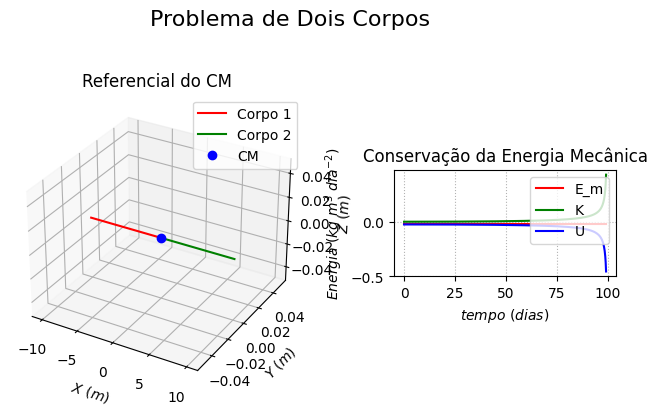

In [10]:
def getEnergy( pos, vel, mass, G ):
	"""
	Get kinetic energy (KE) and potential energy (PE) of simulation
	pos is N x 3 matrix of positions
	vel is N x 3 matrix of velocities
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	KE is the kinetic energy of the system
	PE is the potential energy of the system
	"""
	# Energia Cinética:

	KE = 0.5 * np.sum(np.sum( mass * vel**2 ))


	# Energia Potencial:

	# positions r = [x,y,z] for all particles
	x = pos[:,0:1]
	y = pos[:,1:2]
	z = pos[:,2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z

	# matrix that stores 1/r for all particle pairwise particle separations
	inv_r = np.sqrt(dx**2 + dy**2 + dz**2)
	inv_r[inv_r>0] = 1.0/inv_r[inv_r>0]

	# sum over upper triangle, to count each interaction only once
	PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))

	return KE, PE;


def two_body_motion(_s, _t, _G, _m_1, _m_2):
  """
  differential equations of motion describing the two-body-problem
  _t: discrete time step value
  _y: state vector
  """

  R_1 = _s[:3]
  R_2 = _s[3:6]

  dotR_1 = _s[6:9]
  dotR_2 = _s[9:]

  r = np.sqrt(np.sum(np.square(R_2 - R_1)))

  ddot = _G * (R_2 - R_1) / r**3
  ddotR_1 = _m_2 * ddot
  ddotR_2 = -_m_1 * ddot

  return np.concatenate((dotR_1, dotR_2, ddotR_1, ddotR_2))


t = np.linspace(0, 99, 1000)

# Solução da EDO

tb_solution = odeint(two_body_motion, s_0, t, args=(G, m_1, m_2))

# Resultados da simulação:
state_history = []

for yk in tb_solution:
    # extract inertial positions of body 1 and body 2
    r1 = yk[:3]
    r2 = yk[3:6]

    # determine position of centre of mass
    rg = ((m_1 * r1) + (m_2 * r2)) / (m_1 + m_2)

    # position vector from g to m1
    rg1 = r1 - rg

    # position vector from g to m2
    rg2 = r2 - rg

    # save state history
    state_history.append(np.concatenate((rg1, rg2), axis=None))


# convert list to numpy array
state_history = np.array(state_history)


# Vetor auxiliar para a plotagem dos gráficos
plot_m1 = state_history[:,:3]
plot_m2 = state_history[:,3:6]

# ________________________________
# Análise da Energia
K = []
U = []
Em = []

for i in range(len(tb_solution)):
  pos = np.array([tb_solution[i, 0:3], tb_solution[i, 3:6]])

  vel = np.array([tb_solution[i, 6:9], tb_solution[i, 9:12]])

  mass = np.array([[m_1], [m_2]])

  EK, EU = getEnergy(pos, vel, mass, G)

  K.append(EK)
  U.append(EU)

  Em.append(EK + EU)


# Plotagem dos gráficos:

fig = plt.figure(figsize=plt.figaspect(0.5))
ax_left = fig.add_subplot(10, 13, (15,111), projection='3d')
ax_left.set_title('Referencial do CM')
ax_right = fig.add_subplot(10, 13, (48,77))
ax_right.set_title('Conservação da Energia Mecânica')

#fig = plt.figure(figsize =(10, 10))
#fig = plt.figure(figsize=plt.figaspect(0.5))

ax_left.plot3D(plot_m1[:,0], plot_m1[:,1], plot_m1[:,2], 'red', label='Corpo 1')
ax_left.plot3D(plot_m2[:,0], plot_m2[:,1], plot_m2[:,2], 'green', label='Corpo 2')
ax_left.plot3D([0], [0], [0], 'o', label = 'CM', linewidth = 1, color = 'blue')

ax_left.legend()

ax_left.set_xlabel('$X \ (m)$')
ax_left.set_ylabel('$Y \ (m)$')
ax_left.set_zlabel('$Z \ (m)$')


ax_right.plot(t, Em, 'red', label='E_m')
ax_right.plot(t, K, 'green', label='K')
ax_right.plot(t, U, 'blue', label='U')

ax_right.grid(color='k', linestyle=':', alpha=0.3)
ax_right.set_xlabel('$tempo \ (dias)$')
ax_right.set_ylabel('$Energia \ (kg \ m^3 \ dia^{-2})$')

ax_right.legend()

fig.suptitle('Problema de Dois Corpos', fontsize=16)

fig.tight_layout(pad=3.0)
#ax.dist = 11
plt.show()

## Particular Three Body Problem

In [11]:
# Importando as Bibliotecas necessárias

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

#G = 6.67430e-20  # Constante Gravitacional, km**3/(kg * s**2)
#G = 0.498 #  Constante Gravitacional, m**3/(kg * dia**2)
G = 1.0

# Condições Iniciais 1

m_1 = 1.0/3  # kg
m_2 = 1.0/3  # kg
m_3 = 1.0/3  # kg

R_1_0 = np.array((-0.3092050, 0))  # km
R_2_0 = np.array((0.1546025, -0.09875616))  # km
R_3_0 = np.array((0.1546025,  0.09875616))  # km

dotR_1_0 = np.array((0, -0.50436399))  # km/s
dotR_2_0 = np.array((-1.18437049 * 1.1**2,  0.25218199 * 1.1**2))  # km/s
#dotR_2_0 = np.array((-1.18437049,  0.4))  # km/s
dotR_3_0 = np.array((1.18437049,  0.25218199))  # km/s


s_0 = np.hstack((R_1_0, R_2_0, R_3_0, dotR_1_0, dotR_2_0, dotR_3_0)) # vetor de estado inicial


In [12]:
def three_body_motion(_s, _t, _G, _m_1, _m_2, _m_3):
  """
  differential equations of motion describing the two-body-problem
  _t: discrete time step value
  _y: state vector
  """

  R_1 = _s[:2]
  R_2 = _s[2:4]
  R_3 = _s[4:6]

  dotR_1 = _s[6:8]
  dotR_2 = _s[8:10]
  dotR_3 = _s[10:]

  r12 = np.sqrt(np.sum(np.square(R_2 - R_1)))
  r13 = np.sqrt(np.sum(np.square(R_3 - R_1)))
  r23 = np.sqrt(np.sum(np.square(R_3 - R_2)))

  ddotR_1 = _G * _m_2 * (R_2 - R_1) / r12**3 + _G * _m_3 * (R_3 - R_1) / r13**3
  ddotR_2 = _G * _m_1 * (R_1 - R_2) / r12**3 + _G * _m_3 * (R_3 - R_2) / r23**3
  ddotR_3 = _G * _m_1 * (R_1 - R_3) / r13**3 + _G * _m_2 * (R_2 - R_3) / r23**3

  return np.concatenate((dotR_1, dotR_2, dotR_3, ddotR_1, ddotR_2, ddotR_3))

In [13]:
t = np.linspace(0, 4, 4000)

# Solução da EDO

tb_solution = odeint(three_body_motion, s_0, t, args=(G, m_1, m_2, m_3))


# Vetor auxiliar para a plotagem dos gráficos
plot_m1 = tb_solution[:,:2]
plot_m2 = tb_solution[:,2:4]
plot_m3 = tb_solution[:,4:6]


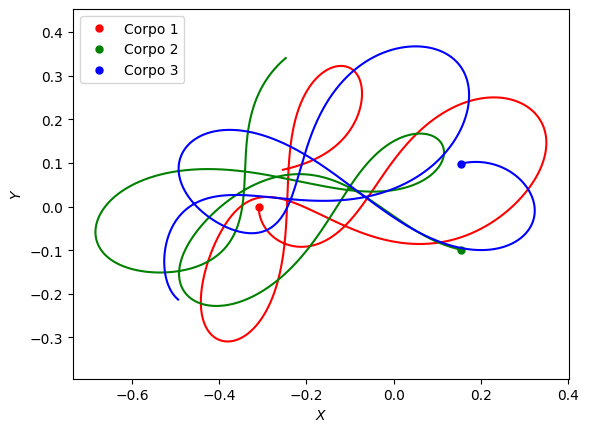

In [14]:
# Plotagem do gráfico:

fig = plt.figure()
ax = plt.axes()

#ax.plot(plot_m1[:,0], plot_m1[:,1], linewidth=1, color='black', zorder=0)


ax.plot(plot_m1[:,0], plot_m1[:,1], 'red')
ax.plot(plot_m2[:,0], plot_m2[:,1], 'green')
ax.plot(plot_m3[:,0], plot_m3[:,1], 'blue')


ax.plot(plot_m1[:,0], plot_m1[:,1], 'red', label='Corpo 1', markevery=[0], marker="o", ms=5, mfc='red', mec='red', linewidth=0, zorder=1)
ax.plot(plot_m2[:,0], plot_m2[:,1], 'green', label='Corpo 2', markevery=[0], marker="o", ms=5, mfc='green', mec='green', linewidth=0, zorder=1)
ax.plot(plot_m3[:,0], plot_m3[:,1], 'blue', label='Corpo 3', markevery=[0], marker="o", ms=5, mfc='blue', mec='blue', linewidth=0, zorder=1)

#plt.plot(x, y, markevery=[0], marker="o", ms=5, linewidth=0, color='black', mfc='blue', mec='blue', zorder=1)

ax.legend()

plt.axis('equal')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')

plt.show()

In [15]:
def getEnergy( pos, vel, mass, G ):
	"""
	Get kinetic energy (KE) and potential energy (PE) of simulation
	pos is N x 3 matrix of positions
	vel is N x 3 matrix of velocities
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	KE is the kinetic energy of the system
	PE is the potential energy of the system
	"""
	# Energia Cinética:

	KE = 0.5 * np.sum(np.sum( mass * vel**2 ))


	# Energia Potencial:

	# positions r = [x,y] for all particles
	x = pos[:,0:1]
	y = pos[:,1:2]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y

	# matrix that stores 1/r for all particle pairwise particle separations
	inv_r = np.sqrt(dx**2 + dy**2)
	inv_r[inv_r>0] = 1.0/inv_r[inv_r>0]

	# sum over upper triangle, to count each interaction only once
	PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))

	return KE, PE;

# Análise da Energia

K = []
U = []
Em = []

for i in range(len(tb_solution)):
  pos = np.array([tb_solution[i, 0:2], tb_solution[i, 2:4], tb_solution[i, 4:6]])

  vel = np.array([tb_solution[i, 6:8], tb_solution[i, 8:10], tb_solution[i, 10:12]])

  mass = np.array([[m_1], [m_2], [m_3]])

  EK, EU = getEnergy(pos, vel, mass, G)

  K.append(EK)
  U.append(EU)

  Em.append(EK + EU)

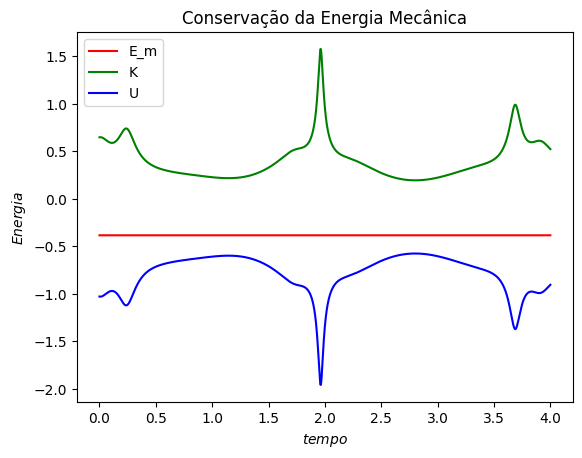

In [16]:
fig = plt.figure()

plt.plot(t, Em, 'red', label='E_m')
plt.plot(t, K, 'green', label='K')
plt.plot(t, U, 'blue', label='U')
plt.legend()

plt.title("Conservação da Energia Mecânica")
plt.xlabel('$tempo$')
plt.ylabel('$Energia$')

plt.show()